In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [69]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [70]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [71]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

## 构建数据集
第 1 步是获得正确形状的数据。我们可以创建一个只包含鸟和飞机的数据集子类。但是，数据集很小，我们只需要索引和 `len()`函数就可以处理数据集。实际上并不一定需要是 `torch.utils.data.dataset.Dataset` 的子类。那么，为什么不采取快捷方式，在 cifar10 中过滤数据，重新映射标签，使它们是连续的呢？方法如下：

In [72]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

cifar2 对象已满足了 Dataset 的基本要求，即已定义了__len__()和__getitem__()函数，因此我们将准备使用它。但是，我们也应该意识到，这只是一个精巧的快捷方式，如果遇到了一些限制，我们可能还是希望实现一个适当的 Dateset 的子类。 

现在我们已经有了一个数据集，下一步我们需要一个模型并将该数据集提供给它。

## 全连接模型
每个样本有多少个特征呢？ 32×32×3，也就是说，每个样本有 3072 个特征。从我们在第 5 章构建的模型开始，我们的新模型将是一个线性模型（ nn.Linear），它有 3072 个输入特征和一些隐藏的特征，接着是一个激活函数，然后另一个线性模型使网络的输出特征逐渐减少到适当的数量（对本例来说，输出特征数量为 2）。

In [73]:
import torch.nn as nn
n_out = 2 # 输出特征数量
model = nn.Sequential(
    nn.Linear(3072, 512), # 3072为输入特征，512为隐藏层大小
    nn.Tanh(),
    nn.Linear(512, n_out) # 输出类
)

我们任意选择 512 个隐藏特征。为了能够像我们在 6.3 节中讨论的那样学习任意函数，一个神经网络至少需要一个隐藏层（激活层，也就是两个模块），否则它将只是一个线性模型。隐藏的特征表示经由权重矩阵编码的输入之间的（学习的）关系。因此，模型可能学会“比较”向量元素 176 和 208，但它不会先验地关注它们，因为它在结构上并不知道这些确实是(第 5 行,像素16)和(第 6 行,像素 16)，从而是相邻的。

## 分类器的输出
我们需要认识到输出是分类的：它要么是一只鸟，要么是一架飞机（如果我们拥有所有原始类的话，也可以是其他的东西）。正如我们在第 4 章中学到的，当我们必须表示一个分类变量时，我们应该用该变量的独热编码表示，如对于飞机使用[1,0]，对于鸟使用[0,1]，顺序任意。如果我们有 10 个类，就像在完整的 CIFAR-10 数据集中一样，该方法仍然有效，我们只需要一个长度为 10 的向量

理想情况下，网络将为飞机输出 torch.tensor([1.0,0.0])，为鸟输出 torch.tensor([0.0,1.0])。实际上，由于我们的分类器并不是很完美的，我们可以期望网络输出介于二者之间的结果。在这种情况下，关键的实现是我们可以将输出解释为概率：第 1 项是“飞机”的概率，第 2 项是“鸟”的概率。

根据概率来处理问题会对我们的网络输出施加一些额外的约束。
- 输出的每个元素必须在[0.0,1.0]的范围内（结果的概率不能小于 0 或大于 1）。
- 输出元素的总和必须为 1.0（我们确信这 2 种结果中的一种将发生）。

这听起来是一个很难用可微的方式对数字向量进行限制的问题，但是有一个非常有用的函数可以做到这一点，而且该函数是可微分的：它叫 Softmax。

## 用概率表示输出
Softmax 是一个函数，它获取一个值向量并生成另一个相同维度的向量，其中的值满足我们刚刚列出的表示概率的约束条件。 Softmax 的表达式如图 7.8 所示。

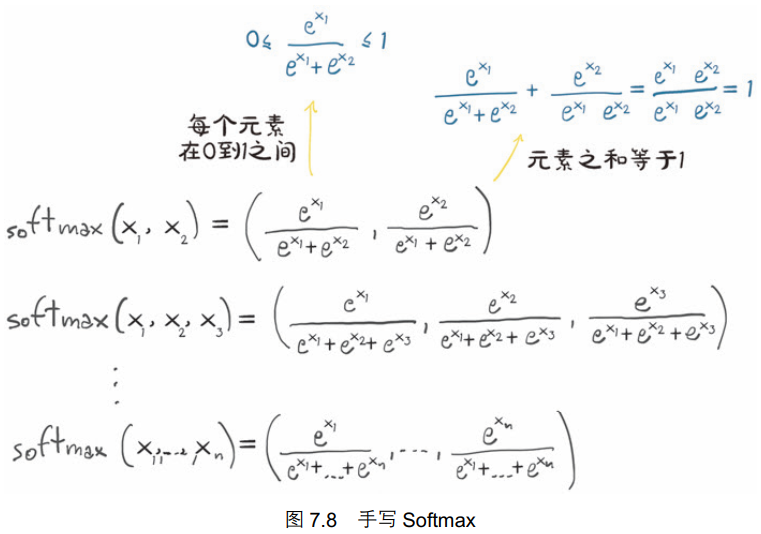

也就是说，我们取向量的元素，计算元素指数， 然后将每个元素除以指数之和。代码如下：

In [74]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

x = torch.tensor([1.0,2.0,3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [75]:
# 正如预期的那样，它满足概率的约束条件
softmax(x).sum()

tensor(1.)

nn 模块将 Softmax 作为一个可用的模块。因为，通常情况下，输入张量可能有额外的第 0 维，或者有它们编码概率的维度，而其他维度没有。 nn.Softmax()要求我们指定用来编码概率的维度：

In [76]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

在本例中，我们在 2 行中有 2 个输入向量（就像我们处理批处理时一样），所以我们初始化nn.Softmax()沿第一维度进行操作。

现在我们可以在模型的末尾添加一个 nn.Softmax()，这样我们的网络就可以产生概率了。

In [77]:
model = nn.Sequential(
    nn.Linear(3072, 512), # 3072为输入特征，512为隐藏层大小
    nn.Tanh(),
    nn.Linear(512, n_out), # 输出类
    nn.Softmax(dim=1))

我们甚至可以在训练模型之前尝试运行它，看看会得到什么。我们首先构建一幅图像，鸟的图像如下图所示

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


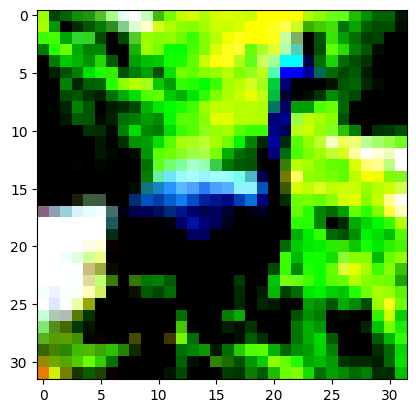

In [78]:
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

为了调用模型，我们需要使输入具有正确的维度。回想一下，我们的模型在输入中期望有3072 个特征，而 nn 处理的是沿着第 0 维成批组织的数据。所以我们需要把 3×32×32 的图像变成一个一维张量，然后在第 0 个位置增加一个维度，我们在第 3 章学习了如何做到这一点：

In [79]:
img_batch = img.view(-1).unsqueeze(0)
# img_batch.shape

# 开始调用模型
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

我们得到了概率，但不要太兴奋，因为线性层的权重和偏置还没有训练过。它们的元素由PyTorch 随机生成的−1.0～1.0 的数据来初始化。有趣的是，我们看到输出中的 grad_fn 属性，它处于后向计算图的顶端（当我们需要反向传播时使用它） 。

当提供一个维度时， torch.max()返回该维度上的最大元素以及该值出现的索引。在我们的例子中，我们需要沿着概率向量取最大值（而不是跨批次），因此维度为 1：

In [80]:
_, index = torch.max(out, dim=1)
index

tensor([1])

## 分类的损失
有一个损失函数是这样的，它被称为负对数似然（ Negative Log Likelihood， NLL）。它的表达式是 `NLL =−sum(log(out_i[c_i]))`，其中 `sum()`用于对 N 个样本求和， 而 `c_i` 是样本 i 的目标类别。让我们看一看图 7.10，它显示了 NLL 作为预测概率的函数。

图 7.10 显示，当预测目标类别的概率较低时， NLL 会增长到无穷大，而当预测目标类别概率大于 0.5 时， NLL 的下降速度非常慢。请记住 NLL 把概率作为输入，所以，随着预测目标类别概率的增加，其他的概率必然会减少。

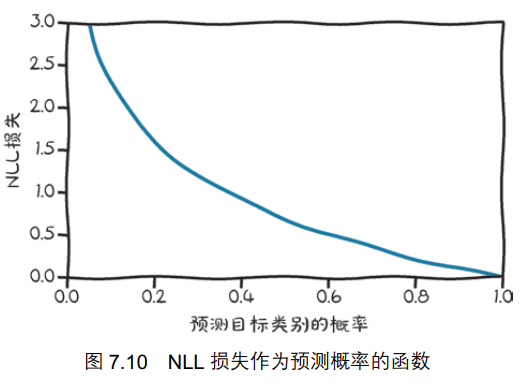

综上所述，对于批次中的每个样本，我们的分类损失可以按如下步骤计算。
1. 运行正向传播，并从最后的线性层获得输出值。
2. 计算它们的 Softmax，并获得概率。
3. 取与目标类别对应的预测概率（参数的可能性）。请注意，我们知道目标类别是什么，这是一个有监督的问题，这是基本事实。
4. 计算它的对数，在它前面加上一个负号，再添加到损失中。

那么，在 PyTorch 中我们该怎么做呢？ PyTorch 有一个 nn.NLLLoss 类，但是与你期望的不同，它没有取概率而是取对数概率张量作为输入。然后在给定一批数据的情况下计算模型的 NLL，输入约定背后的原因是当概率接近 0 时，取概率的对数是很棘手的事情。解决方法是使用nn.LogSoftmax()而不是使用 nn.Softmax()，以确保计算在数字上稳定。

我们现在可以修改模型，使用 nn.LogSoftmax()作为输出模块：

In [81]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

然后我们实例化 NLL 损失：

In [82]:
loss = nn.NLLLoss()

损失将批次的 nn.LogSoftmax()的输出作为第 1 个参数，将类别索引的张量（在我们的例子中是 0 和 1）作为第 2 个参数。我们现在可以用鸟来测试它。

In [83]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

## 训练分类器
我们准备回到第 5 章中编写的训练循环，看看它是如何训练的，训练过程如图 7.12 所示。

In [84]:
import torch.optim as optim
model = nn.Sequential(
    nn.Linear(3072, 512) ,
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 1

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 输出最后一幅图像的损失。在第 8 章中，我们将改进我们的输出，以给出整个迭代周期的平均值
    print("Epoch: %d, Loss: %f" % (epoch, float(loss))) 

Epoch: 0, Loss: 3.150689


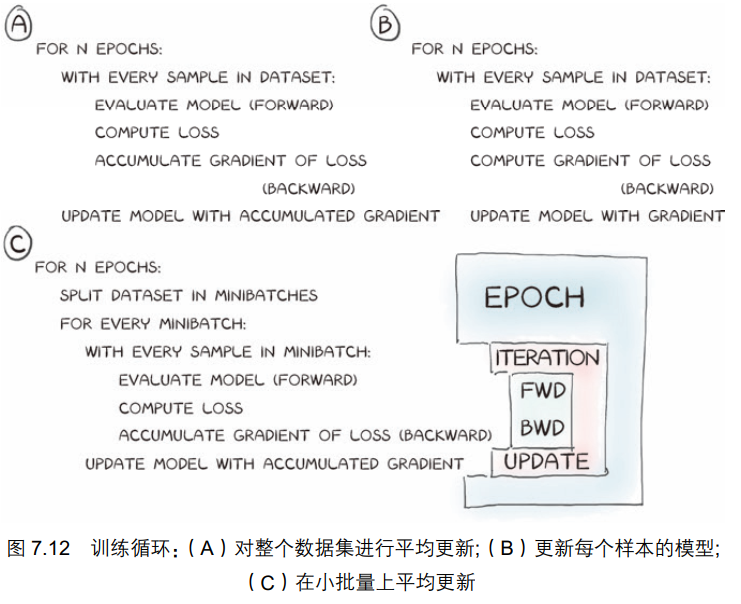

在每个内部迭代中， imgs 是一个 64×3×32×32 的张量，也就是 64 个 32×32 的 RGB 图像的小批量，而 labels 是一个包含标签索引的、大小为 64 的张量。

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2))
model.to(device)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.513201
Epoch: 1, Loss: 0.552241
Epoch: 2, Loss: 0.243259
Epoch: 3, Loss: 0.413211
Epoch: 4, Loss: 0.378918
Epoch: 5, Loss: 0.542152
Epoch: 6, Loss: 0.522416
Epoch: 7, Loss: 0.497802
Epoch: 8, Loss: 0.374265
Epoch: 9, Loss: 0.603725
Epoch: 10, Loss: 0.153594
Epoch: 11, Loss: 0.356688
Epoch: 12, Loss: 0.222505
Epoch: 13, Loss: 0.108661
Epoch: 14, Loss: 0.609750
Epoch: 15, Loss: 0.240440
Epoch: 16, Loss: 0.173242
Epoch: 17, Loss: 0.442052
Epoch: 18, Loss: 0.394501
Epoch: 19, Loss: 0.500508
Epoch: 20, Loss: 0.202437
Epoch: 21, Loss: 0.312044
Epoch: 22, Loss: 0.153963
Epoch: 23, Loss: 0.480229
Epoch: 24, Loss: 0.192506
Epoch: 25, Loss: 0.207641
Epoch: 26, Loss: 0.050225
Epoch: 27, Loss: 0.515963
Epoch: 28, Loss: 0.282366
Epoch: 29, Loss: 0.121603
Epoch: 30, Loss: 0.183161
Epoch: 31, Loss: 0.108082
Epoch: 32, Loss: 0.096580
Epoch: 33, Loss: 0.191994
Epoch: 34, Loss: 0.091277
Epoch: 35, Loss: 0.165774
Epoch: 36, Loss: 0.078164
Epoch: 37, Loss: 0.092949
Epoch: 38, Loss: 0.196

我们看到损失以某种方式减少了，但我们不知道它是否足够低。由于我们的目标是正确地为图像分配类别，并且最好是在独立数据集上这样做，我们可以根据总分类的正确数量来计算验证集上模型的准确性。

In [91]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.809
